# CSE 576 (Spring 2020) Homework 4

Welcome friends, it's time for Deep Learning with PyTorch! This homework might need a longer running time. 
Keep this in mind and start early.

PyTorch is a deep learning framework for fast, flexible experimentation. We are going to use it to train our classifiers.

For this homework you need to turn in this file `hw4.ipynb` after running your results and answering questions in-line.

**Notes**: 
 - This assignment was designed to be used with Google Colab, but feel free to set up your own environment if you wish. Just bear in mind that we cannot provide support for custom environments.
 - Feel free to create new cells as needed, but please **do not delete existing cells**.

Before you get started, we suggest you do the [PyTorch tutorial first](https://github.com/param087/Pytorch-tutorial-on-Google-colab).

You should at least do the 60 Minute Blitz up until "Training a Classifier".

**How to use this notebook:**
 - Each cell with a grey background is executable.
 - They can be executed by pressing the "Play" button or by hitting `Shift+Enter`
 - Cells can be executed out of order.
 - You can add new cells by clicking on the `+ Code` button in the header.
 - Made a mistake a need to start over? Click *(Runtime => Restart runtime)*
 - Check out this [Colab Introduction](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) if you're having trouble.


 This will make sure that your progress will be saved to your Google Drive, and won't be lost if your browser refreshes for some reason. 

## Setup

This will set up the environment without GPUs. This is the recommended setup.

In [1]:
! pip install torch==1.5.0+cpu torchvision==0.6.0+cpu -f https://download.pytorch.org/whl/torch_stable.html 
! pip install tqdm matplotlib

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cpu/torch-1.5.0%2Bcpu-cp36-cp36m-linux_x86_64.whl
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.6.0%2Bcpu-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
# We're not using the GPU.
use_gpu = False

### With GPUs
If you're feeling adventurous you can use GPUs to accelerate training. Follow the following steps. Just note that GPUs might not be available. The course staff also can't provide support for GPU-related issues so if you're having trouble please just use the CPU runtime.

 1. Go to Runtime > Change runtime type and select 'GPU'
 2. Restart the Runtime, uncomment the commands below and run them.

In [1]:
# Install the necessary packages

# ! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html 
# ! pip install tqdm matplotlib

Looking in links: https://download.pytorch.org/whl/torch_stable.html


If you want to use the GPU, uncomment the line below and run it.

In [0]:
# Uncomment this and execute if you're using the GPU.
# use_gpu = True

### Check that things are working.

In [3]:
# Make sure things work.

import torch

if use_gpu:
    print(torch.zeros(10).cuda())
else:
    print(torch.zeros(10))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


 ## Initialize Datasets

 This code defines the data loaders that will be used to train and test our networks. It also defines data augmentation functions.

In [4]:
import torch
import torchvision
from torchvision import transforms

from torch import nn
from torch import optim
import torch.nn.functional as F

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

default_train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize rescales and shifts the data so that it has a zero mean 
    # and unit variance. This reduces bias and makes it easier to learn!
    # The values here are the mean and variance of our inputs.
    # This will change the input images to be centered at 0 and be 
    # between -1 and 1.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

default_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])


def get_train_loader(batch_size, transform=default_train_transform):
    trainset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform)
    return torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=4)


def get_test_loader(batch_size, transform=default_test_transform):
    testset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform) 
    return torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=4)


# This downloads the datasets.
get_train_loader(1)
get_test_loader(1);

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define code that trains and tests code.

This code will train your model. Feel free to read the code below, but we suggest you don't modify it unless you know what you're doing.

In [0]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# The function we'll call to train the network each epoch
def train(net, loader, optimizer, criterion, epoch, use_gpu=False):
    running_loss = 0.0
    total_loss = 0.0

    # Send the network to the correct device
    if use_gpu:
        net = net.cuda()
    else:
        net = net.cpu()

    # tqdm is a useful package for adding a progress bar to your loops
    pbar = tqdm(loader)
    for i, data in enumerate(pbar):
        inputs, labels = data

        # If we're using the GPU, send the data to the GPU
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()  # Set the gradients of the parameters to zero.
        outputs = net(inputs)  # Forward pass (send the images through the network)
        loss = criterion(outputs, labels)  # Compute the loss w.r.t the labels.
        loss.backward()  # Backward pass (compute gradients).
        optimizer.step()  # Use the gradients to update the weights of the network.

        running_loss += loss.item()
        total_loss += loss.item()
        pbar.set_description(f"[epoch {epoch+1}] loss = {running_loss/(i+1):.03f}")
    
    average_loss = total_loss / (i + 1)
    tqdm.write(f"Epoch {epoch} summary -- loss = {average_loss:.03f}")
    
    return average_loss


This code will evaluate the performance of you network. It won't update the weights, just compute from evaluation metrics.

In [0]:
from collections import defaultdict
from torchvision.utils import make_grid
from PIL import Image
from IPython import display as ipd


def show_hard_negatives(hard_negatives, label, nrow=10):
    """Visualizes hard negatives"""
    grid = make_grid([(im+1)/2 for im, score in hard_negatives[label]], 
                     nrow=nrow, padding=1)
    grid = grid.permute(1, 2, 0).mul(255).byte().numpy()
    ipd.display(Image.fromarray((grid)))


# The function we'll call to test the network
def test(net, loader, tag='', use_gpu=False, num_hard_negatives=10):
    correct = 0
    total = 0

    # Send the network to the correct device
    net = net.cuda() if use_gpu else net.cpu()

    # Compute the overall accuracy of the network
    with torch.no_grad():
        for data in tqdm(loader, desc=f"Evaluating {tag}"):
            images, labels = data

            # If we're using the GPU, send the data to the GPU
            if use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            # Forward pass (send the images through the network)
            outputs = net(images)

            # Take the output of the network, and extract the index 
            # of the largest prediction for each example
            _, predicted = torch.max(outputs.data, 1)

            # Count the number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    average_accuracy = correct/total
    tqdm.write(f'{tag} accuracy of the network: {100*average_accuracy:.02f}%')

    # Repeat above, but estimate the testing accuracy for each of the labels
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    hard_negatives = defaultdict(list)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            if use_gpu:
                images = images.cuda()
                labels = labels.cuda()
            outputs = net(images)
            predicted_scores, predicted_labels = torch.max(outputs, 1)
            correct_mask = (predicted_labels == labels).squeeze()
            incorrect_mask = ~correct_mask
            unique_labels, unique_counts = torch.unique(labels, return_counts=True)
            for l, c in zip(unique_labels, unique_counts):
                l = l.item()
                label_mask = (labels == l)
                predicted_mask = (predicted_labels == l)
                # This keeps track of the most hardest negatives
                # i.e. mistakes with the highest confidence.
                hard_negative_mask = (~correct_mask & predicted_mask)
                if hard_negative_mask.sum() > 0:
                    hard_negatives[l].extend([
                        (im, score.item()) 
                        for im, score in zip(images[hard_negative_mask], 
                                             predicted_scores[hard_negative_mask])])
                    hard_negatives[l].sort(key=lambda x: x[1], reverse=True)
                    hard_negatives[l] = hard_negatives[l][:num_hard_negatives]
                class_correct[l] += (correct_mask & label_mask).sum()
                class_total[l] += c


    for i in range(10):
        tqdm.write(f'{tag} accuracy of {classes[i]} = {100*class_correct[i]/class_total[i]:.02f}%')
        if len(hard_negatives[i]) > 0:
            print(f'Hard negatives for {classes[i]}')
            show_hard_negatives(hard_negatives, i, nrow=10)
        else:
            print("There were no hard negatives--perhaps the model got 0% accuracy?")

    
    return average_accuracy

This is a wrapper function we provide that handles all the book keeping. It will train your network for an epoch and then test it every couple epochs.

In [0]:
def train_network(net, 
                  lr, 
                  epochs, 
                  batch_size, 
                  criterion=None,
                  lr_func=None,
                  train_transform=default_train_transform, 
                  eval_interval=1,
                  use_gpu=use_gpu): 
    # Initialize the optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)

    # Initialize the loss function
    if criterion is None:
        # Note that CrossEntropyLoss has the Softmax built in!
        # This is good for numerical stability. 
        # Read: https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss
        criterion = nn.CrossEntropyLoss()

    # Initialize the data loaders
    train_loader = get_train_loader(batch_size, transform=train_transform)
    test_loader = get_test_loader(batch_size)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):  # loop over the dataset multiple times
        if lr_func is not None:
            lr_func(optimizer, epoch, lr)

        train_loss = train(net, train_loader, optimizer, criterion, epoch, use_gpu=use_gpu)
        train_losses.append(train_loss)

        # Evaluate the model every `eval_interval` epochs.
        if (epoch + 1) % eval_interval == 0:
            print(f"Evaluating epoch {epoch+1}")
            train_accuracy = test(net, train_loader, 'Train', use_gpu=use_gpu)
            test_accuracy = test(net, test_loader, 'Test', use_gpu=use_gpu)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
    
    return train_losses, train_accuracies, test_accuracies
    

# A function to plot the losses of single model over time
def plot_results(train_losses, train_accuracies, test_accuracies):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].plot(train_losses)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    
    axes[1].plot(train_accuracies)
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    
    axes[2].plot(test_accuracies)
    axes[2].set_title('Testing Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')

# A function to plot the losses of mutli-model over time
def plot_multi_results(train_losses, train_accuracies, test_accuracies, model_names):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for train_loss, label in zip(train_losses, model_names):
        axes[0].plot(train_loss, label=label)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    for train_acc, label in zip(train_accuracies, model_names):
        axes[1].plot(train_acc, label=label)
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    for test_acc, label in zip(test_accuracies, model_names):
        axes[2].plot(test_acc, label=label)
    axes[2].set_title('Testing Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()


## 2.1. Training a classifier using only one fully connected Layer

Implement a model to classify the images from Cifar-10 into ten categories using just one fully connected layer (remember that fully connected layers are called Linear in PyTorch).

If you are new to PyTorch you may want to check out the tutorial on MNIST [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

Fill in the code for LazyNet here.

**Hints:**
 - Note that `nn.CrossEntropyLoss` has the Softmax built in for numerical stability. This means that the output layer of your network should be linear and not contain a Softmax. You can read more about it [here](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
 - You can use the `view()` function to flatten your input image to a vector e.g., if `x` is a `(100,3,4,4)` tensor then `x.view(-1, 3*4*4)` will flatten it into a vector of size `48`.
 - The images in MNIST are 32x32.

In [8]:
class LazyNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.fc = nn.Linear(32*32*3, 10)

    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        x = x.view(-1, 32*32*3)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

net = LazyNet()
print(net)

LazyNet(
  (fc): Linear(in_features=3072, out_features=10, bias=True)
)


#### Run the model for 15 epochs and report the plots and accuracies.

In [0]:
train_losses, train_accuracies, test_accuracies = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=15,
    eval_interval=1,
    batch_size=1024)

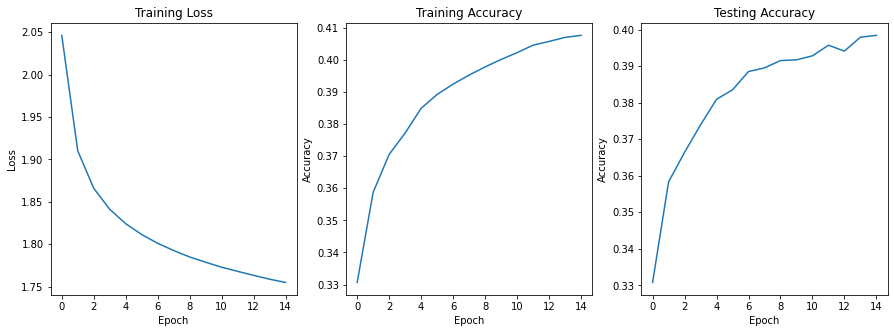

In [0]:
plot_results(train_losses, train_accuracies, test_accuracies)

## 2.2. Training a classifier using multiple fully connected layers ##

Implement a model for the same classification task using multiple fully connected layers.

Start with a fully connected layer that maps the data from image size (32 * 32 * 3) to a vector of size 120, followed by another fully connected that reduces the size to 84 and finally a layer that maps the vector of size 84 to 10 classes.

Use any activation you want.

Fill in the code for BoringNet below.

In [29]:
class BoringNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.fc1 = nn.Linear(32*32*3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

net = BoringNet()
print(net)

BoringNet(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Run the model for 30 epochs and report the plots and accuracies.

In [0]:
train_losses, train_accuracies, test_accuracies = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    eval_interval=1,
    batch_size=1024)

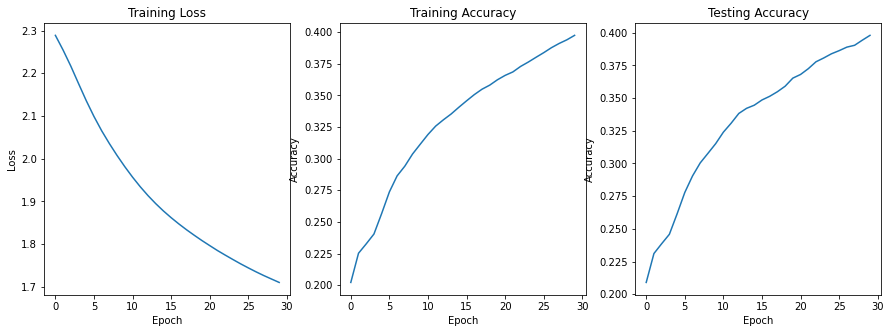

In [31]:
 plot_results(train_losses, train_accuracies, test_accuracies)

### Question

Try training this model with and without activations. How does the activations (such as ReLU) affect the training process and why?


In [0]:
class LinearLazyNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.fc1 = nn.Linear(32*32*3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

net = LinearLazyNet()

train_losses_linear_lazynet, train_accuracies_linear_lazynet, test_accuracies_linear_lazynet = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    eval_interval=1,
    batch_size=1024)

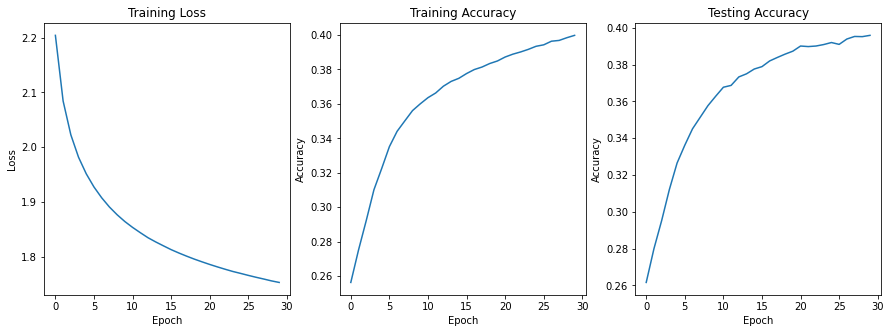

In [36]:
plot_results(train_losses_linear_lazynet, train_accuracies_linear_lazynet, test_accuracies_linear_lazynet)

From model with non-linear activation functions like ReLU will allow the neural network to have outputs rather than simply the linear transformation or combination of the inputs.  Therefore as a classification tasks, we can observe that the model with non-linear activation after each linear layer has a better performance on the testing dataset with a accuracy of $39.79\%$ in comparison to $39.53\%$ as model without activations after 30 epochs each.




## 2.3. Training a classifier using convolutions ##

Implement a model using convolutional, pooling and fully connected layers.

You are free to choose any parameters for these layers (we would like you to play around with some values).

Fill in the code for CoolNet below. Explain why you have chosen these layers and how they affected the performance. Analyze the behavior of your model.

### Run the model for 30 epochs and report the plots and accuracies 

In [0]:
class CoolNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)    
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return x

net = CoolNet()

In [0]:
train_losses_conv, train_accuracies_conv, test_accuracies_conv = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    eval_interval=1,
    batch_size=1024)

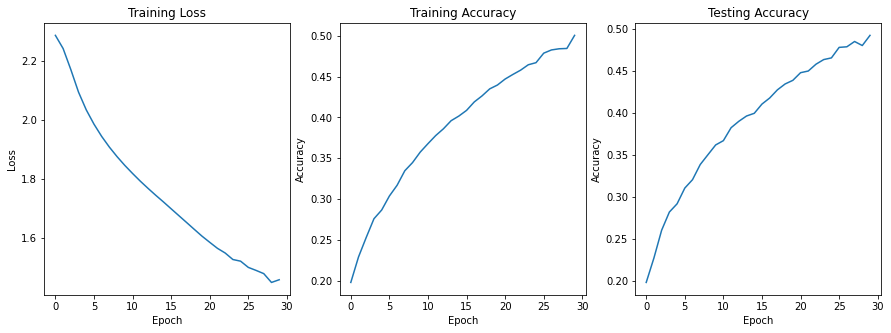

In [12]:
plot_results(train_losses_conv, train_accuracies_conv, test_accuracies_conv)

### 2.3.1. How does batch size affect training?

Try using three different values for batch size. How do these values affect training and why?

In [0]:
net = CoolNet()

train_losses_conv_256, train_accuracies_conv_256, test_accuracies_conv_256 = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    eval_interval=1,
    batch_size=256)

In [15]:
# TODO: Your code here
net = CoolNet()

train_losses_conv_512, train_accuracies_conv_512, test_accuracies_conv_512 = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.1, 
    epochs=30, 
    eval_interval=1,
    batch_size=512)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 1.980
Evaluating epoch 1



Train accuracy of the network: 37.49%



Test accuracy of the network: 37.75%



Epoch 1 summary -- loss = 1.691
Evaluating epoch 2



Train accuracy of the network: 42.30%



Test accuracy of the network: 41.96%



Epoch 2 summary -- loss = 1.539
Evaluating epoch 3



Train accuracy of the network: 49.79%



Test accuracy of the network: 49.57%



Epoch 3 summary -- loss = 1.425
Evaluating epoch 4



Train accuracy of the network: 53.59%



Test accuracy of the network: 52.44%



Epoch 4 summary -- loss = 1.308
Evaluating epoch 5



Train accuracy of the network: 57.10%



Test accuracy of the network: 55.31%



Epoch 5 summary -- loss = 1.215
Evaluating epoch 6



Train accuracy of the network: 56.42%



Test accuracy of the network: 54.52%



Epoch 6 summary -- loss = 1.136
Evaluating epoch 7



Train accuracy of the network: 63.11%



Test accuracy of the network: 59.69%



Epoch 7 summary -- loss = 1.058
Evaluating epoch 8



Train accuracy of the network: 65.53%



Test accuracy of the network: 61.41%



Epoch 8 summary -- loss = 1.002
Evaluating epoch 9



Train accuracy of the network: 65.69%



Test accuracy of the network: 60.99%



Epoch 9 summary -- loss = 0.944
Evaluating epoch 10



Train accuracy of the network: 70.17%



Test accuracy of the network: 63.55%



Epoch 10 summary -- loss = 0.886
Evaluating epoch 11



Train accuracy of the network: 71.72%



Test accuracy of the network: 63.57%



Epoch 11 summary -- loss = 0.832
Evaluating epoch 12



Train accuracy of the network: 73.05%



Test accuracy of the network: 63.95%



Epoch 12 summary -- loss = 0.783
Evaluating epoch 13



Train accuracy of the network: 73.61%



Test accuracy of the network: 63.35%



Epoch 13 summary -- loss = 0.732
Evaluating epoch 14



Train accuracy of the network: 75.79%



Test accuracy of the network: 64.20%



Epoch 14 summary -- loss = 0.674
Evaluating epoch 15



Train accuracy of the network: 80.61%



Test accuracy of the network: 65.97%



Epoch 15 summary -- loss = 0.635
Evaluating epoch 16



Train accuracy of the network: 81.28%



Test accuracy of the network: 66.15%



Epoch 16 summary -- loss = 0.583
Evaluating epoch 17



Train accuracy of the network: 81.73%



Test accuracy of the network: 66.02%



Epoch 17 summary -- loss = 0.533
Evaluating epoch 18



Train accuracy of the network: 85.18%



Test accuracy of the network: 66.66%



Epoch 18 summary -- loss = 0.483
Evaluating epoch 19



Train accuracy of the network: 87.98%



Test accuracy of the network: 67.50%



Epoch 19 summary -- loss = 0.441
Evaluating epoch 20



Train accuracy of the network: 82.97%



Test accuracy of the network: 63.63%



Epoch 20 summary -- loss = 0.392
Evaluating epoch 21



Train accuracy of the network: 83.51%



Test accuracy of the network: 63.62%



Epoch 21 summary -- loss = 0.342
Evaluating epoch 22



Train accuracy of the network: 90.73%



Test accuracy of the network: 65.75%



Epoch 22 summary -- loss = 0.302
Evaluating epoch 23



Train accuracy of the network: 90.17%



Test accuracy of the network: 65.00%



Epoch 23 summary -- loss = 0.288
Evaluating epoch 24



Train accuracy of the network: 94.26%



Test accuracy of the network: 67.06%



Epoch 24 summary -- loss = 0.235
Evaluating epoch 25



Train accuracy of the network: 97.11%



Test accuracy of the network: 67.55%



Epoch 25 summary -- loss = 0.186
Evaluating epoch 26



Train accuracy of the network: 90.48%



Test accuracy of the network: 66.26%



Epoch 26 summary -- loss = 0.179
Evaluating epoch 27



Train accuracy of the network: 99.09%



Test accuracy of the network: 68.25%



Epoch 27 summary -- loss = 0.165
Evaluating epoch 28



Train accuracy of the network: 97.85%



Test accuracy of the network: 67.14%



Epoch 28 summary -- loss = 0.132
Evaluating epoch 29



Train accuracy of the network: 98.89%



Test accuracy of the network: 67.04%



Epoch 29 summary -- loss = 0.051
Evaluating epoch 30



Train accuracy of the network: 99.79%



Test accuracy of the network: 68.14%


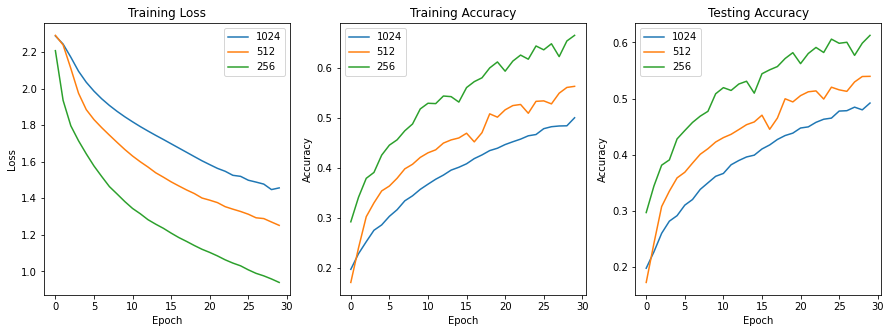

In [39]:
train_losses = [train_losses_conv, train_losses_conv_512, train_losses_conv_256]
train_accuracies = [train_accuracies_conv, train_accuracies_conv_512, train_accuracies_conv_256]
test_accuracies = [test_accuracies_conv, test_accuracies_conv_512, test_accuracies_conv_256]
model_names = ['1024', '512', '256']


plot_multi_results(train_losses, train_accuracies, test_accuracies, model_names)

We observe that smaller batch size will resulted in better performance using the identical model structure. Since the loss used to update the weights is the cumulative error of the entire batch, therefore smaller batch is often noisy in and less general in comparison to larger batch, which offers a regularizing effect and lower generalization error. The testing accuracies for batch size of 256, 512 and 1024 are $68.47\%$, $67.97\%$ and $49.20\%$.

### 2.3.2. How does learning rate work?

When you are trying to train a neural network it is really hard to choose a proper learning rate. 

Try to train your model with different learning rates and plot the training accuracy, test accuracy and loss and compare the training progress for learning rates = 10, 0.1, 0.01, 0.0001.

Analyze the results and choose the best one. Why did you choose this value?



In [0]:
# TODO: Your code here
net = CoolNet()

train_losses_conv_lr10, train_accuracies_conv_lr10, test_accuracies_conv_lr10 = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=10, 
    epochs=30, 
    eval_interval=1,
    batch_size=512)

In [0]:
# TODO: Your code here
net = CoolNet()

train_losses_conv_lr01, train_accuracies_conv_lr01, test_accuracies_conv_lr01 = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.1, 
    epochs=30, 
    eval_interval=1,
    batch_size=512)

In [0]:
# TODO: Your code here
net = CoolNet()

train_losses_conv_lr0001, train_accuracies_conv_lr0001, test_accuracies_conv_lr0001 = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.001, 
    epochs=30, 
    eval_interval=1,
    batch_size=512)

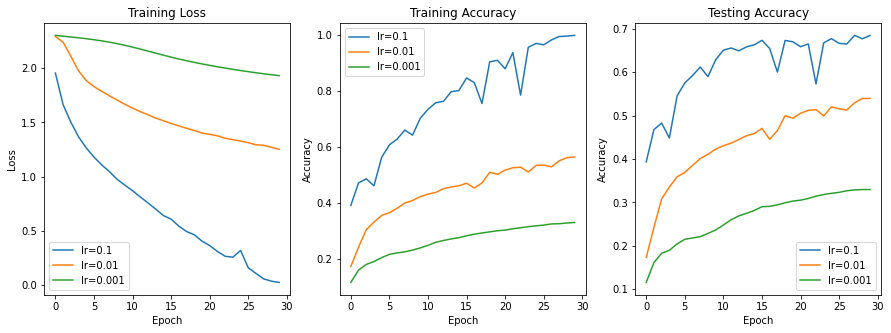

In [44]:
train_losses = [train_losses_conv_lr01, train_losses_conv_512, train_losses_conv_lr0001]
train_accuracies = [train_accuracies_conv_lr01, train_accuracies_conv_512, train_accuracies_conv_lr0001]
test_accuracies = [test_accuracies_conv_lr01, test_accuracies_conv_512, test_accuracies_conv_lr0001]
model_names = ['lr=0.1', 'lr=0.01', 'lr=0.001']


plot_multi_results(train_losses, train_accuracies, test_accuracies, model_names)

In [50]:
test_accuracies_conv_lr01[-1]

0.6844

**Question**:
Analyze the results and choose one value to use. Why did you choose this value?

With a bigger learning rate (e.g. 10^1), the weight updates will be very drastic as the model quickly converges to a suboptimal solution or quickly fall into randomlly predicting the labels as waht happened in our case. With a smaller learning rate (e.g. 10^-3), the model will need far more iterations to train to get to the optimal solution since due to the small weight changes in every update. Therefore, from the experiments we can see that with by selecting a learning rate of 0.1 the model can achieve an highest test accuracy of $68.44\%$. We can also observe that with a learning rate of 0.1, the model also overfit the training dataset.

### 2.3.3. Learning rate scheduling
During training it is often useful to reduce learning rate as the training progresses.

Fill in `set_learning_rate` below to scale the learning rate by 0.1 (reduce by 90%) every 30 epochs and observe the behavior of network for 90 epochs. 


In [0]:
def set_learning_rate(optimizer, epoch, base_lr):
    # TODO: adjust learning rate here
    lr = base_lr * (0.1 ** (epoch//30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [11]:
train_losses_lr_schedule, train_accuracies_lr_schedule, test_accuracies_lr_schedule = train_network(
    net, 
    lr_func=set_learning_rate,
    criterion=nn.CrossEntropyLoss(),
    lr=0.1, 
    epochs=90, 
    eval_interval=1,
    batch_size=512)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 1.984
Evaluating epoch 1



Train accuracy of the network: 38.11%



Test accuracy of the network: 38.52%



Epoch 1 summary -- loss = 1.695
Evaluating epoch 2



Train accuracy of the network: 44.38%



Test accuracy of the network: 44.07%



Epoch 2 summary -- loss = 1.544
Evaluating epoch 3



Train accuracy of the network: 48.41%



Test accuracy of the network: 48.09%



Epoch 3 summary -- loss = 1.414
Evaluating epoch 4



Train accuracy of the network: 51.88%



Test accuracy of the network: 50.82%



Epoch 4 summary -- loss = 1.320
Evaluating epoch 5



Train accuracy of the network: 55.53%



Test accuracy of the network: 53.70%



Epoch 5 summary -- loss = 1.235
Evaluating epoch 6



Train accuracy of the network: 60.56%



Test accuracy of the network: 57.75%



Epoch 6 summary -- loss = 1.163
Evaluating epoch 7



Train accuracy of the network: 59.04%



Test accuracy of the network: 56.15%



Epoch 7 summary -- loss = 1.099
Evaluating epoch 8



Train accuracy of the network: 63.48%



Test accuracy of the network: 59.08%



Epoch 8 summary -- loss = 1.039
Evaluating epoch 9



Train accuracy of the network: 64.83%



Test accuracy of the network: 58.73%



Epoch 9 summary -- loss = 0.976
Evaluating epoch 10



Train accuracy of the network: 63.36%



Test accuracy of the network: 57.57%



Epoch 10 summary -- loss = 0.921
Evaluating epoch 11



Train accuracy of the network: 70.64%



Test accuracy of the network: 62.86%



Epoch 11 summary -- loss = 0.866
Evaluating epoch 12



Train accuracy of the network: 72.77%



Test accuracy of the network: 63.51%



Epoch 12 summary -- loss = 0.816
Evaluating epoch 13



Train accuracy of the network: 74.17%



Test accuracy of the network: 63.61%



Epoch 13 summary -- loss = 0.764
Evaluating epoch 14



Train accuracy of the network: 76.05%



Test accuracy of the network: 64.19%



Epoch 14 summary -- loss = 0.706
Evaluating epoch 15



Train accuracy of the network: 81.10%



Test accuracy of the network: 66.69%



Epoch 15 summary -- loss = 0.659
Evaluating epoch 16



Train accuracy of the network: 79.38%



Test accuracy of the network: 64.97%



Epoch 16 summary -- loss = 0.606
Evaluating epoch 17



Train accuracy of the network: 79.73%



Test accuracy of the network: 63.32%



Epoch 17 summary -- loss = 0.554
Evaluating epoch 18



Train accuracy of the network: 79.38%



Test accuracy of the network: 62.69%



Epoch 18 summary -- loss = 0.511
Evaluating epoch 19



Train accuracy of the network: 85.26%



Test accuracy of the network: 64.93%



Epoch 19 summary -- loss = 0.462
Evaluating epoch 20



Train accuracy of the network: 87.53%



Test accuracy of the network: 65.79%



Epoch 20 summary -- loss = 0.422
Evaluating epoch 21



Train accuracy of the network: 92.07%



Test accuracy of the network: 66.96%



Epoch 21 summary -- loss = 0.364
Evaluating epoch 22



Train accuracy of the network: 87.78%



Test accuracy of the network: 64.67%



Epoch 22 summary -- loss = 0.317
Evaluating epoch 23



Train accuracy of the network: 91.96%



Test accuracy of the network: 65.62%



Epoch 23 summary -- loss = 0.293
Evaluating epoch 24



Train accuracy of the network: 90.69%



Test accuracy of the network: 64.19%



Epoch 24 summary -- loss = 0.237
Evaluating epoch 25



Train accuracy of the network: 96.08%



Test accuracy of the network: 66.11%



Epoch 25 summary -- loss = 0.187
Evaluating epoch 26



Train accuracy of the network: 89.29%



Test accuracy of the network: 61.72%



Epoch 26 summary -- loss = 0.231
Evaluating epoch 27



Train accuracy of the network: 97.02%



Test accuracy of the network: 65.64%



Epoch 27 summary -- loss = 0.128
Evaluating epoch 28



Train accuracy of the network: 99.21%



Test accuracy of the network: 67.28%



Epoch 28 summary -- loss = 0.136
Evaluating epoch 29



Train accuracy of the network: 99.31%



Test accuracy of the network: 67.27%



Epoch 29 summary -- loss = 0.048
Evaluating epoch 30



Train accuracy of the network: 98.32%



Test accuracy of the network: 65.83%



Epoch 30 summary -- loss = 0.030
Evaluating epoch 31



Train accuracy of the network: 99.87%



Test accuracy of the network: 67.31%



Epoch 31 summary -- loss = 0.025
Evaluating epoch 32



Train accuracy of the network: 99.89%



Test accuracy of the network: 67.41%



Epoch 32 summary -- loss = 0.024
Evaluating epoch 33



Train accuracy of the network: 99.90%



Test accuracy of the network: 67.39%



Epoch 33 summary -- loss = 0.023
Evaluating epoch 34



Train accuracy of the network: 99.90%



Test accuracy of the network: 67.40%



Epoch 34 summary -- loss = 0.022
Evaluating epoch 35



Train accuracy of the network: 99.91%



Test accuracy of the network: 67.44%



Epoch 35 summary -- loss = 0.021
Evaluating epoch 36



Train accuracy of the network: 99.91%



Test accuracy of the network: 67.46%



Epoch 36 summary -- loss = 0.020
Evaluating epoch 37



Train accuracy of the network: 99.92%



Test accuracy of the network: 67.38%



Epoch 37 summary -- loss = 0.019
Evaluating epoch 38



Train accuracy of the network: 99.92%



Test accuracy of the network: 67.39%



Epoch 38 summary -- loss = 0.019
Evaluating epoch 39



Train accuracy of the network: 99.93%



Test accuracy of the network: 67.43%



Epoch 39 summary -- loss = 0.018
Evaluating epoch 40



Train accuracy of the network: 99.94%



Test accuracy of the network: 67.40%



Epoch 40 summary -- loss = 0.018
Evaluating epoch 41



Train accuracy of the network: 99.94%



Test accuracy of the network: 67.36%



Epoch 41 summary -- loss = 0.017
Evaluating epoch 42



Train accuracy of the network: 99.95%



Test accuracy of the network: 67.39%



Epoch 42 summary -- loss = 0.017
Evaluating epoch 43



Train accuracy of the network: 99.95%



Test accuracy of the network: 67.31%



Epoch 43 summary -- loss = 0.016
Evaluating epoch 44



Train accuracy of the network: 99.95%



Test accuracy of the network: 67.35%



Epoch 44 summary -- loss = 0.016
Evaluating epoch 45



Train accuracy of the network: 99.95%



Test accuracy of the network: 67.39%



Epoch 45 summary -- loss = 0.015
Evaluating epoch 46



Train accuracy of the network: 99.96%



Test accuracy of the network: 67.35%



Epoch 46 summary -- loss = 0.015
Evaluating epoch 47



Train accuracy of the network: 99.96%



Test accuracy of the network: 67.37%



Epoch 47 summary -- loss = 0.015
Evaluating epoch 48



Train accuracy of the network: 99.96%



Test accuracy of the network: 67.30%



Epoch 48 summary -- loss = 0.014
Evaluating epoch 49



Train accuracy of the network: 99.96%



Test accuracy of the network: 67.37%



Epoch 49 summary -- loss = 0.014
Evaluating epoch 50



Train accuracy of the network: 99.96%



Test accuracy of the network: 67.34%



Epoch 50 summary -- loss = 0.014
Evaluating epoch 51



Train accuracy of the network: 99.96%



Test accuracy of the network: 67.37%



Epoch 51 summary -- loss = 0.013
Evaluating epoch 52



Train accuracy of the network: 99.96%



Test accuracy of the network: 67.37%



Epoch 52 summary -- loss = 0.013
Evaluating epoch 53



Train accuracy of the network: 99.96%



Test accuracy of the network: 67.43%



Epoch 53 summary -- loss = 0.013
Evaluating epoch 54



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.36%



Epoch 54 summary -- loss = 0.012
Evaluating epoch 55



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.39%



Epoch 55 summary -- loss = 0.012
Evaluating epoch 56



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.41%



Epoch 56 summary -- loss = 0.012
Evaluating epoch 57



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.39%



Epoch 57 summary -- loss = 0.012
Evaluating epoch 58



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.43%



Epoch 58 summary -- loss = 0.011
Evaluating epoch 59



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.40%



Epoch 59 summary -- loss = 0.011
Evaluating epoch 60



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.31%



Epoch 60 summary -- loss = 0.011
Evaluating epoch 61



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.36%



Epoch 61 summary -- loss = 0.011
Evaluating epoch 62



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.37%



Epoch 62 summary -- loss = 0.011
Evaluating epoch 63



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.37%



Epoch 63 summary -- loss = 0.011
Evaluating epoch 64



Train accuracy of the network: 99.97%



Test accuracy of the network: 67.35%



Epoch 64 summary -- loss = 0.011
Evaluating epoch 65



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.36%



Epoch 65 summary -- loss = 0.011
Evaluating epoch 66



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.33%



Epoch 66 summary -- loss = 0.011
Evaluating epoch 67



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.34%



Epoch 67 summary -- loss = 0.011
Evaluating epoch 68



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.35%



Epoch 68 summary -- loss = 0.011
Evaluating epoch 69



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.36%



Epoch 69 summary -- loss = 0.011
Evaluating epoch 70



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.36%



Epoch 70 summary -- loss = 0.011
Evaluating epoch 71



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.37%



Epoch 71 summary -- loss = 0.011
Evaluating epoch 72



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.39%



Epoch 72 summary -- loss = 0.011
Evaluating epoch 73



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.37%



Epoch 73 summary -- loss = 0.011
Evaluating epoch 74



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.37%



Epoch 74 summary -- loss = 0.011
Evaluating epoch 75



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 75 summary -- loss = 0.010
Evaluating epoch 76



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 76 summary -- loss = 0.010
Evaluating epoch 77



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 77 summary -- loss = 0.010
Evaluating epoch 78



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 78 summary -- loss = 0.010
Evaluating epoch 79



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.37%



Epoch 79 summary -- loss = 0.010
Evaluating epoch 80



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.39%



Epoch 80 summary -- loss = 0.010
Evaluating epoch 81



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 81 summary -- loss = 0.010
Evaluating epoch 82



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 82 summary -- loss = 0.010
Evaluating epoch 83



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 83 summary -- loss = 0.010
Evaluating epoch 84



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.39%



Epoch 84 summary -- loss = 0.010
Evaluating epoch 85



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.40%



Epoch 85 summary -- loss = 0.010
Evaluating epoch 86



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 86 summary -- loss = 0.010
Evaluating epoch 87



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 87 summary -- loss = 0.010
Evaluating epoch 88



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.37%



Epoch 88 summary -- loss = 0.010
Evaluating epoch 89



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.38%



Epoch 89 summary -- loss = 0.010
Evaluating epoch 90



Train accuracy of the network: 99.98%



Test accuracy of the network: 67.39%


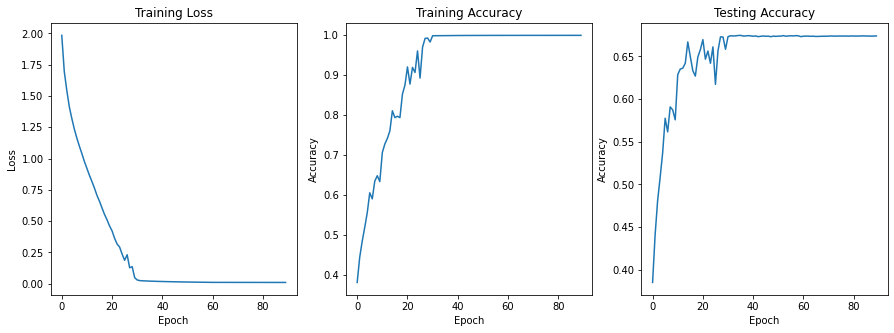

In [13]:
plot_results(train_losses_lr_schedule , train_accuracies_lr_schedule, test_accuracies_lr_schedule)

**Question**: 
What do you observe? Why do you think it is useful to decrease the learning rate over time?

From the previos discussions and results, we know that learning rate will decide the magnitude of the weight updates. Therefore, a larger learning rate may lead the model toward sub-optimal solution even though it converge faster in comparison to smaller learning rate. Therefore by scaling the learning rate by 0.1 every 30 epochs will offer the model different learning rate along the training process which helps to solve such problem. Our model's final testing accuracy is $67.39\%$ after 90 epochs of training.

### 2.3.4. Data Augmentation

Most of the popular computer vision datasets have tens of thousands of images. 

Cifar-10 is a dataset of 60000 32x32 colour images in 10 classes, which can be relatively small in compare to ImageNet which has 1M images. 

The more the number of parameters is, the more likely our model is to overfit to the small dataset. 
As you might have already faced this issue while training the CoolNet, after some iterations the training accuracy reaches its maximum (saturates) while the test accuracy is still relatively low. 

To solve this problem, we use the data augmentation to help the network avoid overfitting.

Add data transformations in to the class below and compare the results. You are free to use any type and any number of data augmentation techniques.

Just be aware that data augmentation should just happen during training phase. 

In [0]:
train_transform = transforms.Compose([
    # TODO: Add data augmentations here
    # You can find a list of transforms here:
    #  https://pytorch.org/docs/stable/torchvision/transforms.html
    # Normalize rescales and shifts the data so that it has a zero mean 
    # and unit variance. This reduces bias and makes it easier to learn!
    # The values here are the mean and variance of our inputs.
    # This will change the input images to be centered at 0 and be 
    # between -1 and 1.
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
train_losses_tran, train_accuracies_tran, test_accuracies_tran = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    train_transform=train_transform,
    lr=0.1, 
    epochs=30, 
    eval_interval=1,
    batch_size=512)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.024
Evaluating epoch 1



Train accuracy of the network: 34.75%



Test accuracy of the network: 35.31%



Epoch 1 summary -- loss = 1.695
Evaluating epoch 2



Train accuracy of the network: 45.50%



Test accuracy of the network: 45.53%



Epoch 2 summary -- loss = 1.545
Evaluating epoch 3



Train accuracy of the network: 46.62%



Test accuracy of the network: 46.46%



Epoch 3 summary -- loss = 1.434
Evaluating epoch 4



Train accuracy of the network: 49.85%



Test accuracy of the network: 49.78%



Epoch 4 summary -- loss = 1.350
Evaluating epoch 5



Train accuracy of the network: 54.84%



Test accuracy of the network: 54.73%



Epoch 5 summary -- loss = 1.281
Evaluating epoch 6



Train accuracy of the network: 58.31%



Test accuracy of the network: 57.50%



Epoch 6 summary -- loss = 1.212
Evaluating epoch 7



Train accuracy of the network: 59.19%



Test accuracy of the network: 58.09%



Epoch 7 summary -- loss = 1.154
Evaluating epoch 8



Train accuracy of the network: 61.51%



Test accuracy of the network: 59.77%



Epoch 8 summary -- loss = 1.103
Evaluating epoch 9



Train accuracy of the network: 59.63%



Test accuracy of the network: 58.16%



Epoch 9 summary -- loss = 1.052
Evaluating epoch 10



Train accuracy of the network: 66.91%



Test accuracy of the network: 64.17%



Epoch 10 summary -- loss = 1.014
Evaluating epoch 11



Train accuracy of the network: 67.61%



Test accuracy of the network: 64.53%



Epoch 11 summary -- loss = 0.964
Evaluating epoch 12



Train accuracy of the network: 68.65%



Test accuracy of the network: 65.50%



Epoch 12 summary -- loss = 0.928
Evaluating epoch 13



Train accuracy of the network: 70.00%



Test accuracy of the network: 66.50%



Epoch 13 summary -- loss = 0.888
Evaluating epoch 14



Train accuracy of the network: 70.23%



Test accuracy of the network: 65.95%



Epoch 14 summary -- loss = 0.856
Evaluating epoch 15



Train accuracy of the network: 70.13%



Test accuracy of the network: 66.34%



Epoch 15 summary -- loss = 0.823
Evaluating epoch 16



Train accuracy of the network: 72.85%



Test accuracy of the network: 67.77%



Epoch 16 summary -- loss = 0.796
Evaluating epoch 17



Train accuracy of the network: 75.57%



Test accuracy of the network: 69.72%



Epoch 17 summary -- loss = 0.769
Evaluating epoch 18



Train accuracy of the network: 76.11%



Test accuracy of the network: 69.61%



Epoch 18 summary -- loss = 0.740
Evaluating epoch 19



Train accuracy of the network: 74.20%



Test accuracy of the network: 67.00%



Epoch 19 summary -- loss = 0.714
Evaluating epoch 20



Train accuracy of the network: 76.97%



Test accuracy of the network: 69.34%



Epoch 20 summary -- loss = 0.691
Evaluating epoch 21



Train accuracy of the network: 77.36%



Test accuracy of the network: 69.77%



Epoch 21 summary -- loss = 0.667
Evaluating epoch 22



Train accuracy of the network: 76.48%



Test accuracy of the network: 68.66%



Epoch 22 summary -- loss = 0.638
Evaluating epoch 23



Train accuracy of the network: 80.19%



Test accuracy of the network: 70.55%



Epoch 23 summary -- loss = 0.615
Evaluating epoch 24



Train accuracy of the network: 80.44%



Test accuracy of the network: 70.72%



Epoch 24 summary -- loss = 0.599
Evaluating epoch 25



Train accuracy of the network: 80.05%



Test accuracy of the network: 70.60%



Epoch 25 summary -- loss = 0.567
Evaluating epoch 26



Train accuracy of the network: 82.83%



Test accuracy of the network: 71.44%



Epoch 26 summary -- loss = 0.544
Evaluating epoch 27



Train accuracy of the network: 83.16%



Test accuracy of the network: 71.33%



Epoch 27 summary -- loss = 0.524
Evaluating epoch 28



Train accuracy of the network: 83.63%



Test accuracy of the network: 71.38%



Epoch 28 summary -- loss = 0.511
Evaluating epoch 29



Train accuracy of the network: 84.03%



Test accuracy of the network: 70.87%



Epoch 29 summary -- loss = 0.486
Evaluating epoch 30



Train accuracy of the network: 84.65%



Test accuracy of the network: 71.33%


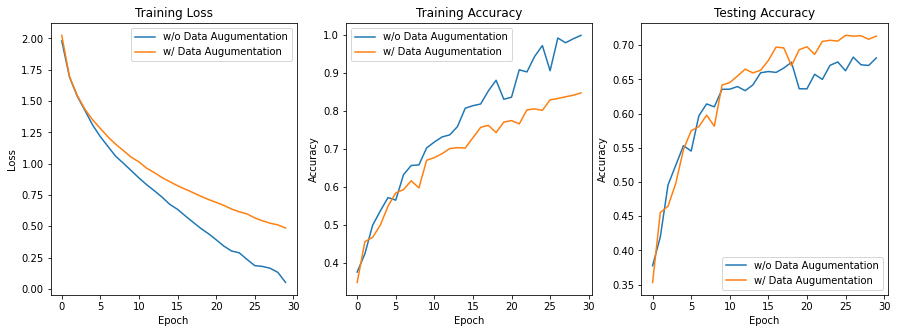

In [19]:
train_losses = [train_losses_conv_512, train_losses_tran]
train_accuracies = [train_accuracies_conv_512, train_accuracies_tran]
test_accuracies = [test_accuracies_conv_512, test_accuracies_tran]
model_names = ['w/o Data Augumentation', 'w/ Data Augumentation']

plot_multi_results(train_losses, train_accuracies, test_accuracies, model_names)

**Question**: How does the model trained with data augmentation compared to the model trained without?

For the data augmentation, we use three different method including image rotate, horizontal image flip and normalization for training images. This will help our model to prevent from overfitting to the training dataset in the sense of enlarging the training samples with more noise therefore increasing the diversity of data without needing to collect actual new images. By comparing the model trained with data augmentation and the model trained without, we can observe that the model trained without data augmentation has a higher training accuracy while the model trained with data augmentation has a higher testing accuracy.

### 2.3.5. Change the loss function

Try Mean Squared Error loss instead of Cross Entropy.

In [13]:
class MSELossClassification(nn.Module):
  def forward(self, output, labels):
    one_hot_encoded_labels = \
      torch.nn.functional.one_hot(labels, num_classes=output.shape[1]).float()
    return nn.functional.mse_loss(output, one_hot_encoded_labels)

train_losses, train_accuracies, test_accuracies = train_network(
    net, 
    criterion=MSELossClassification(),
    lr=0.01, 
    epochs=50, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 0.221
Evaluating epoch 1



Train accuracy of the network: 37.14%



Test accuracy of the network: 37.33%



Epoch 1 summary -- loss = 0.092
Evaluating epoch 2



Train accuracy of the network: 38.53%



Test accuracy of the network: 38.45%



Epoch 2 summary -- loss = 0.084
Evaluating epoch 3



Train accuracy of the network: 39.30%



Test accuracy of the network: 39.10%



Epoch 3 summary -- loss = 0.081
Evaluating epoch 4



Train accuracy of the network: 40.06%



Test accuracy of the network: 39.90%



Epoch 4 summary -- loss = 0.080
Evaluating epoch 5



Train accuracy of the network: 40.42%



Test accuracy of the network: 40.28%



Epoch 5 summary -- loss = 0.079
Evaluating epoch 6



Train accuracy of the network: 40.97%



Test accuracy of the network: 40.87%



Epoch 6 summary -- loss = 0.078
Evaluating epoch 7



Train accuracy of the network: 41.14%



Test accuracy of the network: 41.04%



Epoch 7 summary -- loss = 0.078
Evaluating epoch 8



Train accuracy of the network: 41.53%



Test accuracy of the network: 41.48%



Epoch 8 summary -- loss = 0.077
Evaluating epoch 9



Train accuracy of the network: 41.73%



Test accuracy of the network: 41.53%



Epoch 9 summary -- loss = 0.077
Evaluating epoch 10



Train accuracy of the network: 41.91%



Test accuracy of the network: 41.89%



Epoch 10 summary -- loss = 0.077
Evaluating epoch 11



Train accuracy of the network: 41.89%



Test accuracy of the network: 42.01%



Epoch 11 summary -- loss = 0.077
Evaluating epoch 12



Train accuracy of the network: 42.19%



Test accuracy of the network: 42.26%



Epoch 12 summary -- loss = 0.077
Evaluating epoch 13



Train accuracy of the network: 42.24%



Test accuracy of the network: 42.28%



Epoch 13 summary -- loss = 0.076
Evaluating epoch 14



Train accuracy of the network: 42.33%



Test accuracy of the network: 42.25%



Epoch 14 summary -- loss = 0.076
Evaluating epoch 15



Train accuracy of the network: 42.44%



Test accuracy of the network: 42.54%



Epoch 15 summary -- loss = 0.076
Evaluating epoch 16



Train accuracy of the network: 42.66%



Test accuracy of the network: 42.63%



Epoch 16 summary -- loss = 0.076
Evaluating epoch 17



Train accuracy of the network: 42.66%



Test accuracy of the network: 42.81%



Epoch 17 summary -- loss = 0.076
Evaluating epoch 18



Train accuracy of the network: 42.75%



Test accuracy of the network: 43.10%



Epoch 18 summary -- loss = 0.076
Evaluating epoch 19



Train accuracy of the network: 42.74%



Test accuracy of the network: 42.85%



Epoch 19 summary -- loss = 0.076
Evaluating epoch 20



Train accuracy of the network: 42.82%



Test accuracy of the network: 43.07%



Epoch 20 summary -- loss = 0.076
Evaluating epoch 21



Train accuracy of the network: 43.01%



Test accuracy of the network: 43.06%



Epoch 21 summary -- loss = 0.076
Evaluating epoch 22



Train accuracy of the network: 43.21%



Test accuracy of the network: 43.13%



Epoch 22 summary -- loss = 0.075
Evaluating epoch 23



Train accuracy of the network: 43.19%



Test accuracy of the network: 43.33%



Epoch 23 summary -- loss = 0.075
Evaluating epoch 24



Train accuracy of the network: 43.06%



Test accuracy of the network: 43.31%



Epoch 24 summary -- loss = 0.075
Evaluating epoch 25



Train accuracy of the network: 43.21%



Test accuracy of the network: 43.23%



Epoch 25 summary -- loss = 0.075
Evaluating epoch 26



Train accuracy of the network: 43.28%



Test accuracy of the network: 43.29%



Epoch 26 summary -- loss = 0.075
Evaluating epoch 27



Train accuracy of the network: 43.34%



Test accuracy of the network: 43.60%



Epoch 27 summary -- loss = 0.075
Evaluating epoch 28



Train accuracy of the network: 43.50%



Test accuracy of the network: 43.45%



Epoch 28 summary -- loss = 0.075
Evaluating epoch 29



Train accuracy of the network: 43.43%



Test accuracy of the network: 43.34%



Epoch 29 summary -- loss = 0.075
Evaluating epoch 30



Train accuracy of the network: 43.52%



Test accuracy of the network: 43.61%



Epoch 30 summary -- loss = 0.075
Evaluating epoch 31



Train accuracy of the network: 43.64%



Test accuracy of the network: 43.58%



Epoch 31 summary -- loss = 0.075
Evaluating epoch 32



Train accuracy of the network: 43.85%



Test accuracy of the network: 43.84%



Epoch 32 summary -- loss = 0.075
Evaluating epoch 33



Train accuracy of the network: 43.78%



Test accuracy of the network: 43.78%



Epoch 33 summary -- loss = 0.075
Evaluating epoch 34



Train accuracy of the network: 43.88%



Test accuracy of the network: 43.82%



Epoch 34 summary -- loss = 0.075
Evaluating epoch 35



Train accuracy of the network: 44.04%



Test accuracy of the network: 44.06%



Epoch 35 summary -- loss = 0.074
Evaluating epoch 36



Train accuracy of the network: 44.05%



Test accuracy of the network: 44.10%



Epoch 36 summary -- loss = 0.074
Evaluating epoch 37



Train accuracy of the network: 44.11%



Test accuracy of the network: 44.15%



Epoch 37 summary -- loss = 0.074
Evaluating epoch 38



Train accuracy of the network: 44.04%



Test accuracy of the network: 44.05%



Epoch 38 summary -- loss = 0.074
Evaluating epoch 39



Train accuracy of the network: 44.22%



Test accuracy of the network: 44.14%



Epoch 39 summary -- loss = 0.074
Evaluating epoch 40



Train accuracy of the network: 44.21%



Test accuracy of the network: 44.08%



Epoch 40 summary -- loss = 0.074
Evaluating epoch 41



Train accuracy of the network: 44.36%



Test accuracy of the network: 44.24%



Epoch 41 summary -- loss = 0.074
Evaluating epoch 42



Train accuracy of the network: 44.37%



Test accuracy of the network: 44.27%



Epoch 42 summary -- loss = 0.074
Evaluating epoch 43



Train accuracy of the network: 44.51%



Test accuracy of the network: 44.45%



Epoch 43 summary -- loss = 0.074
Evaluating epoch 44



Train accuracy of the network: 44.61%



Test accuracy of the network: 44.42%



Epoch 44 summary -- loss = 0.074
Evaluating epoch 45



Train accuracy of the network: 44.60%



Test accuracy of the network: 44.42%



Epoch 45 summary -- loss = 0.074
Evaluating epoch 46



Train accuracy of the network: 44.72%



Test accuracy of the network: 44.51%



Epoch 46 summary -- loss = 0.074
Evaluating epoch 47



Train accuracy of the network: 44.77%



Test accuracy of the network: 44.50%



Epoch 47 summary -- loss = 0.074
Evaluating epoch 48



Train accuracy of the network: 44.85%



Test accuracy of the network: 44.84%



Epoch 48 summary -- loss = 0.074
Evaluating epoch 49



Train accuracy of the network: 44.93%



Test accuracy of the network: 44.71%



Epoch 49 summary -- loss = 0.074
Evaluating epoch 50



Train accuracy of the network: 44.91%



Test accuracy of the network: 44.79%


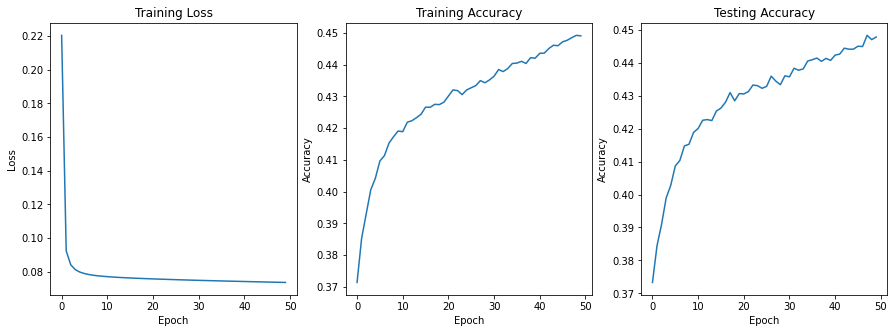

In [15]:
plot_results(train_losses, train_accuracies, test_accuracies)

**Question**:
How does this affects the results? Explain why you think this is happening.

Model trained with MSE loss has a final testing accuracy of $44.79\%$ after 50 epochs of training which is much lower in comparison to model trained with cross-entropy loss. The MSE loss is prefered for regression task, it is not sutiable for such classification task as MSE loss is used when we assumed the error follows normal distribution. In classification task, the error should follws binomial distribution therefore it is nature to use cross-entropy loss.

## Turning In

You're done! You just need to turn in the notebook file.

Go to `File > Download .ipynb` and download the file as `hw4.ipynb`. Turn in only this file.

Make sure that you've answered all questions and all plots are correct.